In [1]:
import time
start = time.time()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
import os

In [2]:
torch.manual_seed(190401009)

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = torch.flatten(x, 1)
        output1 = self.relu(self.fc1(x))
        output2 = self.relu(self.fc2(output1))
        output3 = self.sigmoid(self.fc3(output2))
        return output3

In [4]:
training_data = pd.read_csv("./cure_the_princess_train.csv")
val_data = pd.read_csv("./cure_the_princess_validation.csv")
test_data = pd.read_csv("./cure_the_princess_test.csv")
labels = training_data.columns.tolist()
num_of_classes = len(labels)
train_x = training_data.iloc[:, :-1].values
train_y = training_data.iloc[:, -1].values
val_x = val_data.iloc[:, :-1].values
val_y = val_data.iloc[:, -1].values
test_x = test_data.iloc[:, :-1].values
test_y = test_data.iloc[:, -1].values

In [5]:
class GenerateDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_data = GenerateDataset(train_x, train_y)
val_data = GenerateDataset(val_x, val_y)
test_data = GenerateDataset(test_x, test_y)

In [6]:
learning_rate = 0.002
num_of_epochs = 1500
batch_size = 16
input_size = 13
hidden_size1 = 100
hidden_size2 = 50
output_size = 1
patience = 5

In [7]:
model = MLP(input_size, hidden_size1, hidden_size2, output_size)

In [8]:
# Loss fonksiyonunu belirlemek
criterion = nn.BCELoss()

# Optimizer'ı belirlemek
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
train_loss_list = []
valid_loss_list = []

In [11]:
patience_counter = 0
best_val_loss = None
for epoch in range(num_of_epochs):
    train_loss = 0.0
    train_count = 0.0
    valid_loss = 0.0

    # Eğitim verileri üzerinde eğitim yapmak
    # model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_count += 1
        train_loss += loss.item()

    # Doğrulama verileri üzerinde test yapmak
    with torch.no_grad():
        model.eval()
        for data, target in valid_loader:
            output = model(data)
            loss = criterion(output, target.unsqueeze(1).float())
            valid_loss += loss.item()
    
    model.train()
    # Loss değerlerini kaydetmek
    train_loss /= train_count
    valid_loss /= len(valid_loader)
        
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch + 1, train_loss, valid_loss))
    
    val_score = valid_loss
    if best_val_loss is None:
        best_val_loss = val_score # hafızada patience boyu tutmaya başla
        torch.save(model.state_dict(), "checkpoint.pt")
    elif best_val_loss < val_score: # patience counter
        patience_counter += 1
        print("Earlystopping Patience Counter:",patience_counter)
        #if patience_counter == patience:
            #break
    else:
        best_val_loss = val_score
        torch.save(model.state_dict(), "checkpoint.pt") # to keep the best model
        patience_counter = 0

Epoch: 1 	Training Loss: 0.641133 	Validation Loss: 0.536121
Epoch: 2 	Training Loss: 0.511008 	Validation Loss: 0.439666
Epoch: 3 	Training Loss: 0.447327 	Validation Loss: 0.385598
Epoch: 4 	Training Loss: 0.406941 	Validation Loss: 0.357239
Epoch: 5 	Training Loss: 0.370913 	Validation Loss: 0.310232
Epoch: 6 	Training Loss: 0.350413 	Validation Loss: 0.297793
Epoch: 7 	Training Loss: 0.326837 	Validation Loss: 0.279600
Epoch: 8 	Training Loss: 0.314716 	Validation Loss: 0.274871
Epoch: 9 	Training Loss: 0.296443 	Validation Loss: 0.244278
Epoch: 10 	Training Loss: 0.291339 	Validation Loss: 0.317069
Earlystopping Patience Counter: 1
Epoch: 11 	Training Loss: 0.286619 	Validation Loss: 0.259947
Earlystopping Patience Counter: 2
Epoch: 12 	Training Loss: 0.272505 	Validation Loss: 0.228332
Epoch: 13 	Training Loss: 0.269761 	Validation Loss: 0.219796
Epoch: 14 	Training Loss: 0.259677 	Validation Loss: 0.214589
Epoch: 15 	Training Loss: 0.254515 	Validation Loss: 0.208844
Epoch: 16 	

Epoch: 103 	Training Loss: 0.083947 	Validation Loss: 0.149156
Earlystopping Patience Counter: 7
Epoch: 104 	Training Loss: 0.082516 	Validation Loss: 0.134062
Epoch: 105 	Training Loss: 0.080765 	Validation Loss: 0.150681
Earlystopping Patience Counter: 1
Epoch: 106 	Training Loss: 0.079299 	Validation Loss: 0.136258
Earlystopping Patience Counter: 2
Epoch: 107 	Training Loss: 0.080860 	Validation Loss: 0.141455
Earlystopping Patience Counter: 3
Epoch: 108 	Training Loss: 0.078616 	Validation Loss: 0.136134
Earlystopping Patience Counter: 4
Epoch: 109 	Training Loss: 0.079433 	Validation Loss: 0.142546
Earlystopping Patience Counter: 5
Epoch: 110 	Training Loss: 0.080010 	Validation Loss: 0.136553
Earlystopping Patience Counter: 6
Epoch: 111 	Training Loss: 0.084927 	Validation Loss: 0.204768
Earlystopping Patience Counter: 7
Epoch: 112 	Training Loss: 0.079057 	Validation Loss: 0.150840
Earlystopping Patience Counter: 8
Epoch: 113 	Training Loss: 0.075185 	Validation Loss: 0.139250
E

Epoch: 189 	Training Loss: 0.039854 	Validation Loss: 0.152657
Earlystopping Patience Counter: 85
Epoch: 190 	Training Loss: 0.041391 	Validation Loss: 0.159122
Earlystopping Patience Counter: 86
Epoch: 191 	Training Loss: 0.040754 	Validation Loss: 0.154102
Earlystopping Patience Counter: 87
Epoch: 192 	Training Loss: 0.038928 	Validation Loss: 0.164978
Earlystopping Patience Counter: 88
Epoch: 193 	Training Loss: 0.039735 	Validation Loss: 0.166706
Earlystopping Patience Counter: 89
Epoch: 194 	Training Loss: 0.039365 	Validation Loss: 0.167463
Earlystopping Patience Counter: 90
Epoch: 195 	Training Loss: 0.041264 	Validation Loss: 0.155284
Earlystopping Patience Counter: 91
Epoch: 196 	Training Loss: 0.039383 	Validation Loss: 0.158131
Earlystopping Patience Counter: 92
Epoch: 197 	Training Loss: 0.039753 	Validation Loss: 0.155817
Earlystopping Patience Counter: 93
Epoch: 198 	Training Loss: 0.040088 	Validation Loss: 0.162691
Earlystopping Patience Counter: 94
Epoch: 199 	Training

Epoch: 273 	Training Loss: 0.023466 	Validation Loss: 0.184694
Earlystopping Patience Counter: 169
Epoch: 274 	Training Loss: 0.022335 	Validation Loss: 0.191883
Earlystopping Patience Counter: 170
Epoch: 275 	Training Loss: 0.024028 	Validation Loss: 0.233460
Earlystopping Patience Counter: 171
Epoch: 276 	Training Loss: 0.022935 	Validation Loss: 0.183505
Earlystopping Patience Counter: 172
Epoch: 277 	Training Loss: 0.022836 	Validation Loss: 0.187448
Earlystopping Patience Counter: 173
Epoch: 278 	Training Loss: 0.022710 	Validation Loss: 0.195835
Earlystopping Patience Counter: 174
Epoch: 279 	Training Loss: 0.022708 	Validation Loss: 0.191327
Earlystopping Patience Counter: 175
Epoch: 280 	Training Loss: 0.022564 	Validation Loss: 0.188554
Earlystopping Patience Counter: 176
Epoch: 281 	Training Loss: 0.021691 	Validation Loss: 0.218169
Earlystopping Patience Counter: 177
Epoch: 282 	Training Loss: 0.023157 	Validation Loss: 0.185010
Earlystopping Patience Counter: 178
Epoch: 283

Epoch: 356 	Training Loss: 0.015065 	Validation Loss: 0.216424
Earlystopping Patience Counter: 252
Epoch: 357 	Training Loss: 0.014768 	Validation Loss: 0.206767
Earlystopping Patience Counter: 253
Epoch: 358 	Training Loss: 0.014523 	Validation Loss: 0.211929
Earlystopping Patience Counter: 254
Epoch: 359 	Training Loss: 0.014454 	Validation Loss: 0.208210
Earlystopping Patience Counter: 255
Epoch: 360 	Training Loss: 0.014923 	Validation Loss: 0.211892
Earlystopping Patience Counter: 256
Epoch: 361 	Training Loss: 0.014588 	Validation Loss: 0.213684
Earlystopping Patience Counter: 257
Epoch: 362 	Training Loss: 0.013687 	Validation Loss: 0.204502
Earlystopping Patience Counter: 258
Epoch: 363 	Training Loss: 0.014140 	Validation Loss: 0.213465
Earlystopping Patience Counter: 259
Epoch: 364 	Training Loss: 0.013697 	Validation Loss: 0.215122
Earlystopping Patience Counter: 260
Epoch: 365 	Training Loss: 0.014295 	Validation Loss: 0.205869
Earlystopping Patience Counter: 261
Epoch: 366

Epoch: 440 	Training Loss: 0.009897 	Validation Loss: 0.222022
Earlystopping Patience Counter: 336
Epoch: 441 	Training Loss: 0.009920 	Validation Loss: 0.230953
Earlystopping Patience Counter: 337
Epoch: 442 	Training Loss: 0.009982 	Validation Loss: 0.222432
Earlystopping Patience Counter: 338
Epoch: 443 	Training Loss: 0.009892 	Validation Loss: 0.224680
Earlystopping Patience Counter: 339
Epoch: 444 	Training Loss: 0.009431 	Validation Loss: 0.225216
Earlystopping Patience Counter: 340
Epoch: 445 	Training Loss: 0.009645 	Validation Loss: 0.221330
Earlystopping Patience Counter: 341
Epoch: 446 	Training Loss: 0.009407 	Validation Loss: 0.232482
Earlystopping Patience Counter: 342
Epoch: 447 	Training Loss: 0.009425 	Validation Loss: 0.225460
Earlystopping Patience Counter: 343
Epoch: 448 	Training Loss: 0.010179 	Validation Loss: 0.221564
Earlystopping Patience Counter: 344
Epoch: 449 	Training Loss: 0.009636 	Validation Loss: 0.223925
Earlystopping Patience Counter: 345
Epoch: 450

Epoch: 524 	Training Loss: 0.006838 	Validation Loss: 0.235341
Earlystopping Patience Counter: 420
Epoch: 525 	Training Loss: 0.007264 	Validation Loss: 0.253718
Earlystopping Patience Counter: 421
Epoch: 526 	Training Loss: 0.007399 	Validation Loss: 0.251274
Earlystopping Patience Counter: 422
Epoch: 527 	Training Loss: 0.006679 	Validation Loss: 0.239659
Earlystopping Patience Counter: 423
Epoch: 528 	Training Loss: 0.006889 	Validation Loss: 0.247898
Earlystopping Patience Counter: 424
Epoch: 529 	Training Loss: 0.006790 	Validation Loss: 0.240206
Earlystopping Patience Counter: 425
Epoch: 530 	Training Loss: 0.007116 	Validation Loss: 0.242679
Earlystopping Patience Counter: 426
Epoch: 531 	Training Loss: 0.006364 	Validation Loss: 0.251166
Earlystopping Patience Counter: 427
Epoch: 532 	Training Loss: 0.006419 	Validation Loss: 0.240364
Earlystopping Patience Counter: 428
Epoch: 533 	Training Loss: 0.006280 	Validation Loss: 0.240956
Earlystopping Patience Counter: 429
Epoch: 534

Epoch: 608 	Training Loss: 0.005144 	Validation Loss: 0.248981
Earlystopping Patience Counter: 504
Epoch: 609 	Training Loss: 0.004931 	Validation Loss: 0.258520
Earlystopping Patience Counter: 505
Epoch: 610 	Training Loss: 0.005128 	Validation Loss: 0.259315
Earlystopping Patience Counter: 506
Epoch: 611 	Training Loss: 0.005226 	Validation Loss: 0.246269
Earlystopping Patience Counter: 507
Epoch: 612 	Training Loss: 0.004909 	Validation Loss: 0.246488
Earlystopping Patience Counter: 508
Epoch: 613 	Training Loss: 0.005263 	Validation Loss: 0.245395
Earlystopping Patience Counter: 509
Epoch: 614 	Training Loss: 0.004878 	Validation Loss: 0.261737
Earlystopping Patience Counter: 510
Epoch: 615 	Training Loss: 0.005155 	Validation Loss: 0.253775
Earlystopping Patience Counter: 511
Epoch: 616 	Training Loss: 0.005059 	Validation Loss: 0.249116
Earlystopping Patience Counter: 512
Epoch: 617 	Training Loss: 0.005114 	Validation Loss: 0.247957
Earlystopping Patience Counter: 513
Epoch: 618

Epoch: 692 	Training Loss: 0.003943 	Validation Loss: 0.268137
Earlystopping Patience Counter: 588
Epoch: 693 	Training Loss: 0.003943 	Validation Loss: 0.262271
Earlystopping Patience Counter: 589
Epoch: 694 	Training Loss: 0.004060 	Validation Loss: 0.256157
Earlystopping Patience Counter: 590
Epoch: 695 	Training Loss: 0.004040 	Validation Loss: 0.265855
Earlystopping Patience Counter: 591
Epoch: 696 	Training Loss: 0.003772 	Validation Loss: 0.259691
Earlystopping Patience Counter: 592
Epoch: 697 	Training Loss: 0.004280 	Validation Loss: 0.323979
Earlystopping Patience Counter: 593
Epoch: 698 	Training Loss: 0.004350 	Validation Loss: 0.254990
Earlystopping Patience Counter: 594
Epoch: 699 	Training Loss: 0.003886 	Validation Loss: 0.259201
Earlystopping Patience Counter: 595
Epoch: 700 	Training Loss: 0.003739 	Validation Loss: 0.260790
Earlystopping Patience Counter: 596
Epoch: 701 	Training Loss: 0.003886 	Validation Loss: 0.260495
Earlystopping Patience Counter: 597
Epoch: 702

Epoch: 776 	Training Loss: 0.003142 	Validation Loss: 0.266500
Earlystopping Patience Counter: 672
Epoch: 777 	Training Loss: 0.003057 	Validation Loss: 0.265496
Earlystopping Patience Counter: 673
Epoch: 778 	Training Loss: 0.003195 	Validation Loss: 0.268128
Earlystopping Patience Counter: 674
Epoch: 779 	Training Loss: 0.003113 	Validation Loss: 0.265683
Earlystopping Patience Counter: 675
Epoch: 780 	Training Loss: 0.003024 	Validation Loss: 0.268054
Earlystopping Patience Counter: 676
Epoch: 781 	Training Loss: 0.002971 	Validation Loss: 0.268166
Earlystopping Patience Counter: 677
Epoch: 782 	Training Loss: 0.002939 	Validation Loss: 0.265147
Earlystopping Patience Counter: 678
Epoch: 783 	Training Loss: 0.002964 	Validation Loss: 0.262749
Earlystopping Patience Counter: 679
Epoch: 784 	Training Loss: 0.003015 	Validation Loss: 0.263712
Earlystopping Patience Counter: 680
Epoch: 785 	Training Loss: 0.003005 	Validation Loss: 0.271746
Earlystopping Patience Counter: 681
Epoch: 786

Epoch: 860 	Training Loss: 0.002737 	Validation Loss: 0.287461
Earlystopping Patience Counter: 756
Epoch: 861 	Training Loss: 0.002618 	Validation Loss: 0.272892
Earlystopping Patience Counter: 757
Epoch: 862 	Training Loss: 0.002585 	Validation Loss: 0.270177
Earlystopping Patience Counter: 758
Epoch: 863 	Training Loss: 0.002582 	Validation Loss: 0.277086
Earlystopping Patience Counter: 759
Epoch: 864 	Training Loss: 0.002538 	Validation Loss: 0.276341
Earlystopping Patience Counter: 760
Epoch: 865 	Training Loss: 0.002525 	Validation Loss: 0.273313
Earlystopping Patience Counter: 761
Epoch: 866 	Training Loss: 0.002406 	Validation Loss: 0.269536
Earlystopping Patience Counter: 762
Epoch: 867 	Training Loss: 0.002533 	Validation Loss: 0.273262
Earlystopping Patience Counter: 763
Epoch: 868 	Training Loss: 0.002527 	Validation Loss: 0.275876
Earlystopping Patience Counter: 764
Epoch: 869 	Training Loss: 0.002481 	Validation Loss: 0.271257
Earlystopping Patience Counter: 765
Epoch: 870

Epoch: 944 	Training Loss: 0.002161 	Validation Loss: 0.277180
Earlystopping Patience Counter: 840
Epoch: 945 	Training Loss: 0.002164 	Validation Loss: 0.277267
Earlystopping Patience Counter: 841
Epoch: 946 	Training Loss: 0.002140 	Validation Loss: 0.281542
Earlystopping Patience Counter: 842
Epoch: 947 	Training Loss: 0.002165 	Validation Loss: 0.280759
Earlystopping Patience Counter: 843
Epoch: 948 	Training Loss: 0.002099 	Validation Loss: 0.282656
Earlystopping Patience Counter: 844
Epoch: 949 	Training Loss: 0.002352 	Validation Loss: 0.287501
Earlystopping Patience Counter: 845
Epoch: 950 	Training Loss: 0.002119 	Validation Loss: 0.287408
Earlystopping Patience Counter: 846
Epoch: 951 	Training Loss: 0.002170 	Validation Loss: 0.285461
Earlystopping Patience Counter: 847
Epoch: 952 	Training Loss: 0.002110 	Validation Loss: 0.281038
Earlystopping Patience Counter: 848
Epoch: 953 	Training Loss: 0.002078 	Validation Loss: 0.275686
Earlystopping Patience Counter: 849
Epoch: 954

Epoch: 1028 	Training Loss: 0.001882 	Validation Loss: 0.284200
Earlystopping Patience Counter: 924
Epoch: 1029 	Training Loss: 0.001850 	Validation Loss: 0.285282
Earlystopping Patience Counter: 925
Epoch: 1030 	Training Loss: 0.001857 	Validation Loss: 0.284447
Earlystopping Patience Counter: 926
Epoch: 1031 	Training Loss: 0.001815 	Validation Loss: 0.286622
Earlystopping Patience Counter: 927
Epoch: 1032 	Training Loss: 0.001866 	Validation Loss: 0.285635
Earlystopping Patience Counter: 928
Epoch: 1033 	Training Loss: 0.001814 	Validation Loss: 0.290029
Earlystopping Patience Counter: 929
Epoch: 1034 	Training Loss: 0.001830 	Validation Loss: 0.290707
Earlystopping Patience Counter: 930
Epoch: 1035 	Training Loss: 0.001817 	Validation Loss: 0.282303
Earlystopping Patience Counter: 931
Epoch: 1036 	Training Loss: 0.001853 	Validation Loss: 0.286092
Earlystopping Patience Counter: 932
Epoch: 1037 	Training Loss: 0.001743 	Validation Loss: 0.281751
Earlystopping Patience Counter: 933


Epoch: 1112 	Training Loss: 0.001608 	Validation Loss: 0.288038
Earlystopping Patience Counter: 1008
Epoch: 1113 	Training Loss: 0.001576 	Validation Loss: 0.291950
Earlystopping Patience Counter: 1009
Epoch: 1114 	Training Loss: 0.001602 	Validation Loss: 0.294361
Earlystopping Patience Counter: 1010
Epoch: 1115 	Training Loss: 0.001565 	Validation Loss: 0.291679
Earlystopping Patience Counter: 1011
Epoch: 1116 	Training Loss: 0.001606 	Validation Loss: 0.289152
Earlystopping Patience Counter: 1012
Epoch: 1117 	Training Loss: 0.001632 	Validation Loss: 0.290110
Earlystopping Patience Counter: 1013
Epoch: 1118 	Training Loss: 0.001612 	Validation Loss: 0.292627
Earlystopping Patience Counter: 1014
Epoch: 1119 	Training Loss: 0.001601 	Validation Loss: 0.290395
Earlystopping Patience Counter: 1015
Epoch: 1120 	Training Loss: 0.001583 	Validation Loss: 0.291066
Earlystopping Patience Counter: 1016
Epoch: 1121 	Training Loss: 0.001575 	Validation Loss: 0.293900
Earlystopping Patience Coun

Epoch: 1196 	Training Loss: 0.001376 	Validation Loss: 0.298291
Earlystopping Patience Counter: 1092
Epoch: 1197 	Training Loss: 0.001406 	Validation Loss: 0.297716
Earlystopping Patience Counter: 1093
Epoch: 1198 	Training Loss: 0.001428 	Validation Loss: 0.297283
Earlystopping Patience Counter: 1094
Epoch: 1199 	Training Loss: 0.001427 	Validation Loss: 0.296694
Earlystopping Patience Counter: 1095
Epoch: 1200 	Training Loss: 0.001396 	Validation Loss: 0.295520
Earlystopping Patience Counter: 1096
Epoch: 1201 	Training Loss: 0.001404 	Validation Loss: 0.298668
Earlystopping Patience Counter: 1097
Epoch: 1202 	Training Loss: 0.001347 	Validation Loss: 0.291902
Earlystopping Patience Counter: 1098
Epoch: 1203 	Training Loss: 0.001443 	Validation Loss: 0.295196
Earlystopping Patience Counter: 1099
Epoch: 1204 	Training Loss: 0.001443 	Validation Loss: 0.299324
Earlystopping Patience Counter: 1100
Epoch: 1205 	Training Loss: 0.001436 	Validation Loss: 0.297772
Earlystopping Patience Coun

Epoch: 1280 	Training Loss: 0.001291 	Validation Loss: 0.300627
Earlystopping Patience Counter: 1176
Epoch: 1281 	Training Loss: 0.001261 	Validation Loss: 0.302777
Earlystopping Patience Counter: 1177
Epoch: 1282 	Training Loss: 0.001291 	Validation Loss: 0.303281
Earlystopping Patience Counter: 1178
Epoch: 1283 	Training Loss: 0.001275 	Validation Loss: 0.300812
Earlystopping Patience Counter: 1179
Epoch: 1284 	Training Loss: 0.001245 	Validation Loss: 0.299909
Earlystopping Patience Counter: 1180
Epoch: 1285 	Training Loss: 0.001254 	Validation Loss: 0.305041
Earlystopping Patience Counter: 1181
Epoch: 1286 	Training Loss: 0.001244 	Validation Loss: 0.303131
Earlystopping Patience Counter: 1182
Epoch: 1287 	Training Loss: 0.001261 	Validation Loss: 0.303288
Earlystopping Patience Counter: 1183
Epoch: 1288 	Training Loss: 0.001259 	Validation Loss: 0.299480
Earlystopping Patience Counter: 1184
Epoch: 1289 	Training Loss: 0.001245 	Validation Loss: 0.304807
Earlystopping Patience Coun

Epoch: 1364 	Training Loss: 0.001129 	Validation Loss: 0.305592
Earlystopping Patience Counter: 1260
Epoch: 1365 	Training Loss: 0.001136 	Validation Loss: 0.303172
Earlystopping Patience Counter: 1261
Epoch: 1366 	Training Loss: 0.001160 	Validation Loss: 0.303177
Earlystopping Patience Counter: 1262
Epoch: 1367 	Training Loss: 0.001122 	Validation Loss: 0.305027
Earlystopping Patience Counter: 1263
Epoch: 1368 	Training Loss: 0.001132 	Validation Loss: 0.301163
Earlystopping Patience Counter: 1264
Epoch: 1369 	Training Loss: 0.001138 	Validation Loss: 0.302431
Earlystopping Patience Counter: 1265
Epoch: 1370 	Training Loss: 0.001123 	Validation Loss: 0.302131
Earlystopping Patience Counter: 1266
Epoch: 1371 	Training Loss: 0.001131 	Validation Loss: 0.305511
Earlystopping Patience Counter: 1267
Epoch: 1372 	Training Loss: 0.001159 	Validation Loss: 0.306418
Earlystopping Patience Counter: 1268
Epoch: 1373 	Training Loss: 0.001136 	Validation Loss: 0.304739
Earlystopping Patience Coun

Epoch: 1448 	Training Loss: 0.001028 	Validation Loss: 0.309377
Earlystopping Patience Counter: 1344
Epoch: 1449 	Training Loss: 0.001027 	Validation Loss: 0.308006
Earlystopping Patience Counter: 1345
Epoch: 1450 	Training Loss: 0.001024 	Validation Loss: 0.308417
Earlystopping Patience Counter: 1346
Epoch: 1451 	Training Loss: 0.001039 	Validation Loss: 0.306853
Earlystopping Patience Counter: 1347
Epoch: 1452 	Training Loss: 0.001029 	Validation Loss: 0.310840
Earlystopping Patience Counter: 1348
Epoch: 1453 	Training Loss: 0.001021 	Validation Loss: 0.308889
Earlystopping Patience Counter: 1349
Epoch: 1454 	Training Loss: 0.001009 	Validation Loss: 0.306467
Earlystopping Patience Counter: 1350
Epoch: 1455 	Training Loss: 0.001034 	Validation Loss: 0.307989
Earlystopping Patience Counter: 1351
Epoch: 1456 	Training Loss: 0.000995 	Validation Loss: 0.304917
Earlystopping Patience Counter: 1352
Epoch: 1457 	Training Loss: 0.001043 	Validation Loss: 0.307409
Earlystopping Patience Coun

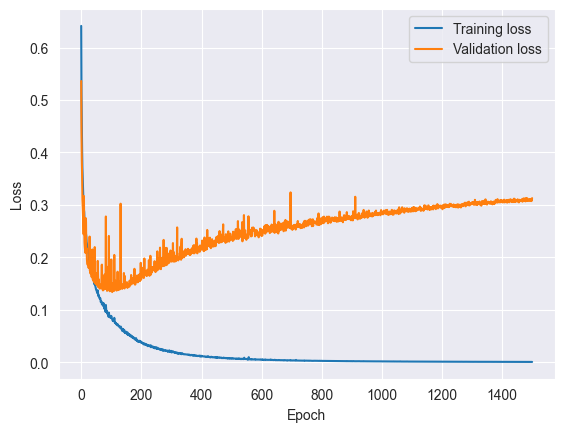

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.plot(train_loss_list, label="Training loss")
plt.plot(valid_loss_list, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model.load_state_dict(torch.load('checkpoint.pt'))

preds = []
tlabels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = torch.round(outputs)
        preds.extend(predicted.detach().cpu().numpy())
        tlabels.extend(labels.detach().cpu().numpy())

accuracy = accuracy_score(tlabels, preds)
f1 = f1_score(tlabels, preds)
precision = precision_score(tlabels, preds)
recall = recall_score(tlabels, preds)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 0.9585
F1 score: 0.9578
Precision: 0.9811
Recall: 0.9356


In [14]:
end = time.time()
elapsed = end - start
print("Elapsed:", f'{elapsed:.2f}', "secs")

Elapsed: 167.33 secs
